# SEIRD Model for the Coronavirus Pandemic Crisis

The first step to begin the simulation is to determine the differential equations reggarding the model. The SEIRD model divides the population into 5 groups, those suseptible to the disease $S(t)$, those who got the disease, but didn't develop symptoms yet $E(t)$, the ones who are infected and already show symptoms $I(t)$, those who recovered from the disease and acquried immunicity and at last, the ones who sadly died from the disease $D(t)$. The behavior of these populations is governed by exchanging rates, that is, rates in which individuals leave on gruop and get to another group.

First, the rate of infection $\lambda$ is proportional to the number of infected people and of exposed people (if you consider that people who does not yet show symptoms still infect others), so we write $\lambda(t) = \beta I(t) + kE(t)$. The rate in which people leave the exposed grupo and get to the infected group is assumed constant, proportional to the inverse of the incubation period, $c = 1/\tau$, where $\tau$ is the incubation period. Finally, the rates of recovery and of death are also assumed constants and proportional to the inverse of the average time taken from symptoms development to full recovery and from symptoms development to death, respectively.

With that in hands, we build the equations for the $S$ population

$$\frac{dS}{dt} = -\beta I(t) S(t) - kE(t) S(t)$$

the $E$ population

$$\frac{dE}{dt} = \beta I(t) S(t) + kE(t) S(t) - cE(t)$$

the $I$ population

$$\frac{dI}{dt} = cE(t) - \alpha I(t) - \mu I(t)$$

the $R$ population

$$\frac{dR}{dt} = \alpha I(t)$$

and the $D$ population

$$\frac{dD}{dt} = \mu I(t)$$

One last step before working on the code is to define initial conditions, let us assume that our population has a size $N$ and at time $t = 0$ we introduce $I_0$ infected people. On these conditions, when $t = 0$, $S(0) = N - I_0$, $R(0) = D(0) = E(0) = 0$ and $I(0) = I_0$. If $N$ is large enough compared to $I_0$ (which is quite often the real case), $S(0) \approx N$.

Now we begin working on the code, first we write all the packages we are going to use.

In [151]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

Now let us define our function to solve the set of differential equations. Let's call $x$ a vector of size 5, where each component represents one population, $x = (S, E, I, R, D)$. After that, we choose some parameters $\beta, c, k, \alpha$ and $\mu$ and write the equations relating the componentes of $x$.

In [3]:
def Corona(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    b = 0.00000027
    a = 0.0320
    mu = 0.0159
    c = 1/5.3
    k = b*0.55
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

Now let's imput our initial conditions and the lenth of time we want to study, say 200 days.

In [4]:
N = 1e6
I0 = 300

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

The function ''odeint'' from scipy.integrate solves the set of equations we determined with our specific initial conditions for the time interval we choose. And after that we just need to redefine our populations in terms of the result ''odeint'' acquired.

In [6]:
y = odeint(Corona, x0, t)

S = y[:,0]
E = y[:,1]
I = y[:,2]
R = y[:,3]
D = y[:,4]

It is convinient to also define the cumulative number of infections, since that is a number that countries keep track of. The cumulative number of infections is the total number of infections occurred at a given time $t$, since everybody who got infected at some time $t' < t$ is now either still infected, or dead, or recovered, we define the cumulative number as $CT = I + R + D$.

In [7]:
CT = I + R + D

We can now plot the results from our simulation on a graph to observe how the populations behaved.

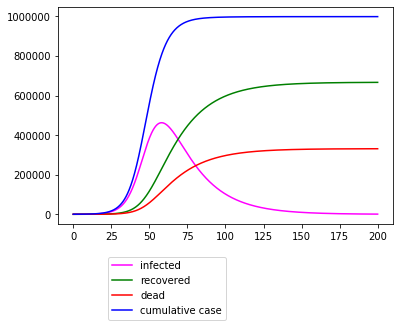

In [10]:
plt.plot(t, I, label = 'infected', color = 'magenta')
plt.plot(t, R, label = 'recovered', color = 'green')
plt.plot(t, D, label = 'dead', color = 'red')
plt.plot(t, CT, label = 'cumulative case', color = 'blue')
lgd = plt.legend(bbox_to_anchor=(0.15, -0.15), loc='upper left', borderaxespad=0.)

That's nice, but now let's try to work out some non-pharmaceutical interventions, such as a lock-down or quarantine measure. How they affect the system?
In the core of $\beta$, we have some factors proportional to the number of daily physical contacts you have with other people, and the probability of infection on each encounter, which is related to the viral charge released on the contact. Therefore we may write $\beta = P_{infec} C$, where $P_{infec}$ is the probability of infection and $C$ is the average number of contacts.

It may be noted that any non-pharmaceutical intervention messes either with $C$ (on a quarantine for example) or on $P_{infec}$ (like the use of masks by infected individuals). Then, we can represent the variation of these parameters as a variation of $\beta$. We choose the following model for that description:

$\beta$ starts at some constant value $\beta_i$ and at some time $t_c$ a non-pharmaceutical intervention is implemented, decreasing $\beta$ to another value $\beta_f$, which is some percentage of $\beta_i$. In reality, it takes some time for $\beta$ to decrease. Once a government implements a quarantine, for example, it takes some time for the population to ajust to this measure and the quarantine get to it's objective. The function that respects this behavior is a modified logistic function.

$$\beta = \frac{P_o\beta_i}{1+\gamma e^{(t-t_c)}} + (1-P_o) \beta_i$$

Here, $P_o$ is the aim decrease for the measure, in percentage, and $\gamma$ is a constant related to the time it takes for the measure to achive it's objective.

Let's us now evaluate the behavior of $\beta$ on a graph where we want to decrease $\beta$ by 70%, meaning $P_o = 0.7$ and let us assume that the quarantine takes 10 days to be fully effective.

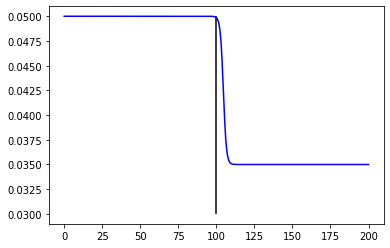

In [14]:
bi = 0.05
Po = 0.3
gamma = 0.01
tc = 100
b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi

plt.plot(t, b, color = 'blue')
plt.vlines(tc, 0.03, 0.05, color = 'black')

Now, we rebuild our model, substituting $\beta$

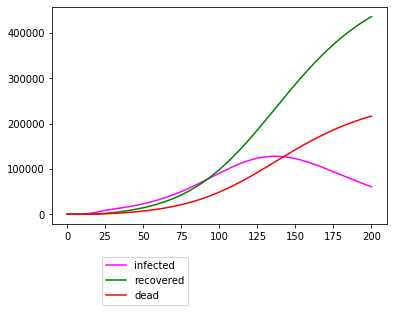

In [21]:
def Corona2(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.00000027
    Po = 0.7
    gamma = 0.01
    tc = 15
    b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi
    a = 0.0320
    mu = 0.0159
    c = 1/5.3
    k = b*0.55
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 1e6
I0 = 300

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona2, x0, t)

S2 = y[:,0]
E2 = y[:,1]
I2 = y[:,2]
R2 = y[:,3]
D2 = y[:,4]

plt.plot(t, I2, label = 'infected', color = 'magenta')
plt.plot(t, R2, label = 'recovered', color = 'green')
plt.plot(t, D2, label = 'dead', color = 'red')
lgd = plt.legend(bbox_to_anchor=(0.15, -0.15), loc='upper left', borderaxespad=0.)

Let us compare the new curve for infected with the one achived by considering no intervention.

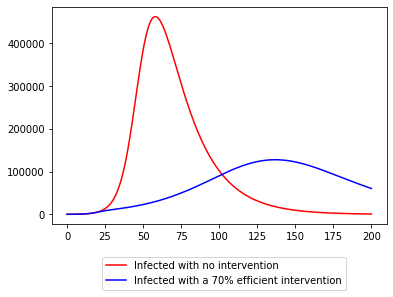

In [22]:
plt.plot(t, I, label = 'Infected with no intervention', color = 'red')
plt.plot(t, I2, label = 'Infected with a 70% efficient intervention', color = 'blue')
lgd = plt.legend(bbox_to_anchor=(0.15, -0.15), loc='upper left', borderaxespad=0.)

That is interesting, now let's evaluate the effect of $t_c$, that is, the day in which the interventation begins. For that let's create the functions corona3, corona4, and corona5. All of them with the same parameters and the same population, but corona3 will have $t_c = 15$ while for corona4 and corona5 we set $t_c = 25$ and $t_c = 35$ respectively.

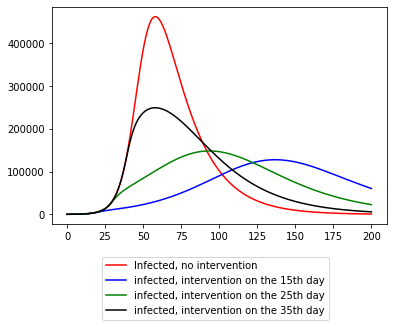

In [27]:
def Corona3(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.00000027
    Po = 0.7
    gamma = 0.01
    tc = 15
    b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi
    a = 0.0320
    mu = 0.0159
    c = 1/5.3
    k = b*0.55
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 1e6
I0 = 300

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona3, x0, t)

S3 = y[:,0]
E3 = y[:,1]
I3 = y[:,2]
R3 = y[:,3]
D3 = y[:,4]

def Corona4(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.00000027
    Po = 0.7
    gamma = 0.01
    tc = 25
    b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi
    a = 0.0320
    mu = 0.0159
    c = 1/5.3
    k = b*0.55
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 1e6
I0 = 300

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona4, x0, t)

S4 = y[:,0]
E4 = y[:,1]
I4 = y[:,2]
R4 = y[:,3]
D4 = y[:,4]

def Corona5(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.00000027
    Po = 0.7
    gamma = 0.01
    tc = 35
    b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi
    a = 0.0320
    mu = 0.0159
    c = 1/5.3
    k = b*0.55
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 1e6
I0 = 300

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona5, x0, t)

S5 = y[:,0]
E5 = y[:,1]
I5 = y[:,2]
R5 = y[:,3]
D5 = y[:,4]

plt.plot(t, I, label = 'Infected, no intervention', color = 'red')
plt.plot(t, I3, label = 'infected, intervention on the 15th day', color = 'blue')
plt.plot(t, I4, label = 'infected, intervention on the 25th day', color = 'green')
plt.plot(t, I5, label = 'infected, intervention on the 35th day', color = 'black')
lgd = plt.legend(bbox_to_anchor=(0.15, -0.15), loc='upper left', borderaxespad=0.)

A huge difference is seen on the black curve when compared to the blue and green ones, but there's a much lighter difference between the green and blue curves. That happens because both of them happened on a period where the rise of the infected curve as still low. While the black curve represents a situation where the intervention is imposed on a period where the slope of the curve is already too high.

It is also possible to study the effect of stoping the intervention. We need to place another function on $\beta$ exactly equal to the one used to decrease it, but invert the sign of the term on the exponential on $\beta$ and assign the day of stop.

$$\beta = \frac{P_o\beta_i}{1+\gamma e^{(t-t_c)}} + (1-P_o) \beta_i + \frac{P_o\beta_i}{1+\gamma e^{-(t-t_s)}},$$

where $t_s$ is the stoping day. For example, suppose the intervention begins on the 25th day and stops at the 50th day, or the 60th day or the 70th day. In this case

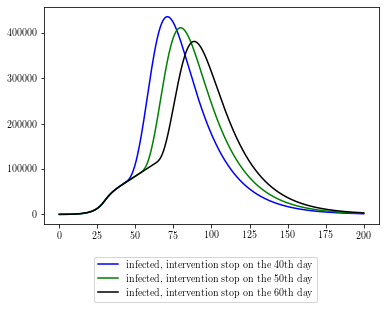

In [68]:
def Corona7(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.00000027
    Po = 0.7
    gamma = 0.01
    tc = 25
    ts = 50
    b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi + (Po*bi)/(1 + gamma*np.exp(-t+ts))
    a = 0.0320
    mu = 0.0159
    c = 1/5.3
    k = b*0.55
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 1e6
I0 = 300

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona7, x0, t)

S7 = y[:,0]
E7 = y[:,1]
I7 = y[:,2]
R7 = y[:,3]
D7 = y[:,4]

def Corona8(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.00000027
    Po = 0.7
    gamma = 0.01
    tc = 25
    ts = 60
    b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi + (Po*bi)/(1 + gamma*np.exp(-t+ts))
    a = 0.0320
    mu = 0.0159
    c = 1/5.3
    k = b*0.55
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 1e6
I0 = 300

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona8, x0, t)

S8 = y[:,0]
E8 = y[:,1]
I8 = y[:,2]
R8 = y[:,3]
D8 = y[:,4]

def Corona9(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.00000027
    Po = 0.7
    gamma = 0.01
    tc = 25
    ts = 70
    b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi + (Po*bi)/(1 + gamma*np.exp(-t+ts))
    a = 0.0320
    mu = 0.0159
    c = 1/5.3
    k = b*0.55
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 1e6
I0 = 300

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona9, x0, t)

S9 = y[:,0]
E9 = y[:,1]
I9 = y[:,2]
R9 = y[:,3]
D9 = y[:,4]

plt.plot(t, I7, label = 'infected, intervention stop on the 40th day', color = 'blue')
plt.plot(t, I8, label = 'infected, intervention stop on the 50th day', color = 'green')
plt.plot(t, I9, label = 'infected, intervention stop on the 60th day', color = 'black')
lgd = plt.legend(bbox_to_anchor=(0.15, -0.15), loc='upper left', borderaxespad=0.)

Here it is possible to notice that when the intervention stops to early, the curve still grows to much, and the later we stop, the lower the peak.

# SEIRD Model with age division

Now let's build a more complex model. We know that the COVID-19 acts differently on different ages. To take that into account, let's build an SEIRD model where we have $M$ age groups, each i-th group with $N_i$ members. The parameters $\alpha$, $\mu$, $\beta$, $k$ and $c$ should now be different on each of the $M$ groups, but since $c$ depends only on the biology of the virus and it's mechanism of action, we set $c$ equal in all age groups. Another modification is done on $\mu$ and $\alpha$, they will be proportional to the probability of dying or recovering on each group, for example, according to https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/ the mortality rate of COVID-19 on people between 10-19 years is 0.2%, therefor $\mu \rightarrow \mu' = P_{:C} \mu$ where $P_{:C}$ (yes, it is a sad face) is the probability of dying, in this case $\mu' = 0.002\mu$. Since the probability of dying is 0.02%, the probability of recovering is 99.8%, so $\alpha' = 0.998\alpha$.

The more complex change is on $\beta$, since now we must take into account the average number of contacts between groups, i. e. members of a group $i$ interact with members of a group $j$. Assuming that $P_{infec}$ is the same for all age groups, we change $\beta$ to $\beta_{i}$, where

$$\beta_{i} = \sum_{j}^{M} P_{infec} C_{ij}.$$

What we are doing here is a sum over all interactions a member of the group $i$ had with members in all other groups, including his own.

A simple way of visualizing this situation is thinking that a child of 10 years, goes to school and interacts with children of 10 years as well and the professor of 30 years, for example. Then the child goes home and interacts with it's parents of 40 and 38 years. After lunch, the same child goes to the coffee shop to buy some snacks and interacts with some teenagers of 16 years...

Fortunatelly, some studies were done on some european countries measuring exactly that! The average number of social contacts per day that a person of some specific age has with others with different ages. The matrix for different countries can be found on https://lwillem.shinyapps.io/socrates_rshiny/ as well as the studies that contributed to this values.

Another thing to take into consideration is the distribution of the population by ages, the United Nations provides some predictions for how the world population must be aranged in each country by the year of 2020 https://population.un.org/wpp/.


Let us develop now a code for simulating the SEIRD model with age division. We will divide the population in 8 age groups: 0-9yrs, 10-19yrs, 20-29yrs, 30-39yrs, 40-49yrs, 50-59yrs, 60-69yrs, +70yrs. And we are goint to use the United Nations prediction for Brazil on 2020.

According to UN, on 2020 the population of Brazil is composed of:

0-9yrs = 13.7%

10-19yrs = 14.6%

20-29yrs = 16%

30-39yrs = 16.2%

40-49yrs = 13.9%

50-59yrs = 11.5%

60-69yrs = 8%

+70yrs = 6.1%

Unfortunatelly, there's no study to evaluate the social contact matrix for Brazil, so we choose to use the one with the highest values on https://lwillem.shinyapps.io/socrates_rshiny/, that is, Poland's matrix. We choose this as the most appropriate case to simulate the brazilian culture of high levels of physical contacts.

To develop the code, we divide each of the disease groups into 8 other groups, making a total of 40 groups and 40 equations to work with :)

Here we discuss some values for the parameters, we can set any parameter the way we want. The only warning is that N cannot be the total population!

Why? You ask me!

Because the whole SEIRD model is based on the assumption that the population is homogeneou distributed troughout the territory, which is not true. We can compensate this by decreasing $N$ to an effective value, that carries the meaning of effective population. That means that, due to spatial distribution on population, the spreading of the disease does not tend to infect everyone, just some part of the population. That part is our representation of $N$. For Brazil, a simples approximation is to use only the population of regions around the focus of the disease. With that approximation, we could sum the populations of the cities and regions of São Paulo, Pernambuco, Rio de Janeiro and Distrito Federal and set it equal to our $N$

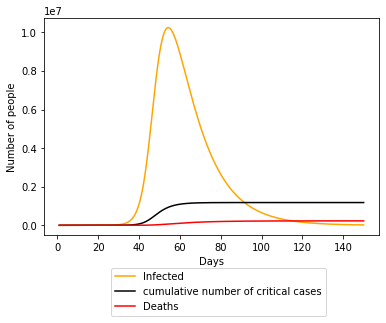

In [8]:
 def Corona6(x,t):
    S1 = x[0]
    E1 = x[1]
    I1 = x[2]
    R1 = x[3]
    M1 = x[4]
    
    S2 = x[5]
    E2 = x[6]
    I2 = x[7]
    R2 = x[8]
    M2 = x[9]
    
    S3 = x[10]
    E3 = x[11]
    I3 = x[12]
    R3 = x[13]
    M3 = x[14]
    
    S4 = x[15]
    E4 = x[16]
    I4 = x[17]
    R4 = x[18]
    M4 = x[19]
    
    S5 = x[20]
    E5 = x[21]
    I5 = x[22]
    R5 = x[23]
    M5 = x[24]
    
    S6 = x[25]
    E6 = x[26]
    I6 = x[27]
    R6 = x[28]
    M6 = x[29]
    
    S7 = x[30]
    E7 = x[31]
    I7 = x[32]
    R7 = x[33]
    M7 = x[34]
    
    S8 = x[35]
    E8 = x[36]
    I8 = x[37]
    R8 = x[38]
    M8 = x[39]
    
    N = 23.6e6
    N1 = 0.137*N
    N2 = 0.146*N
    N3 = 0.160*N
    N4 = 0.162*N
    N5 = 0.139*N
    N6 = 0.115*N
    N7 = 0.080*N
    N8 = 0.061*N
    N = N1 + N2 + N3 + N4 + N5 + N6
    #MATRIZ DA POLONIA
    Cij = np.array([
        [3.21, 0.88, 0.96, 1.39, 0.58, 0.80, 0.43, 0.33],
        [0.56, 8.46, 1.05, 0.96, 0.89, 0.46, 0.26, 0.28],
        [0.50, 0.86, 4.92, 1.33, 1.06, 1.08, 0.26, 0.22],
        [0.91, 0.98, 1.65, 2.89, 1.68, 1.20, 0.54, 0.40],
        [0.35, 0.84, 1.24, 1.57, 2.22, 1.19, 0.42, 0.43],
        [0.48, 0.44, 1.24, 1.12, 1.18, 1.80, 0.53, 0.50],
        [0.44, 0.42, 0.52, 0.86, 0.71, 0.91, 0.91, 0.47],
        [0.33, 0.44, 0.41, 0.61, 0.70, 0.81, 0.45, 0.90]
        ])
    
    a = 0.071
    c = 1/5.2
    mu = 0.053
    Pb = 0.11
    Pk = Pb*0.08
    Ej = np.array([E1,E2,E3,E4,E5,E6,E7,E8])
    Ij = np.array([I1,I2,I3,I4,I5,I6,I7,I8])
    B1j = sum(Cij[0,:]*Ij)
    k1j = sum(Cij[0,:]*Ej)
    
    B1 = (B1j*Pb/N1)
    c1 = c
    a1 = 10*a
    mu1 = 0
    k1 = k1j*Pk/N1 
    dS1dt = -B1*S1 - k1*S1
    dE1dt = B1*S1 - c1*E1 + k1*S1
    dI1dt = c1*E1 - a1*I1 - mu1*I1
    dR1dt = a1*I1
    dM1dt = mu1*I1
    
    
    B2j = sum(Cij[1,:]*Ij)
    k2j = sum(Cij[1,:]*Ej)
    
    B2 = (B2j*Pb/N2)
    c2 = c
    a2 = (1-0.002)*a
    mu2 = 0.002*mu
    k2 = k2j*Pk/N2
    dS2dt = -B2*S2 - k2*S2
    dE2dt = B2*S2 - c2*E2 + k2*S2
    dI2dt = c2*E2 - a2*I2 - mu2*I2
    dR2dt = a2*I2
    dM2dt = mu2*I2
    
    
    B3j = sum(Cij[2,:]*Ij)
    k3j = sum(Cij[2,:]*Ej)
    
    B3 = (B3j*Pb/N3)
    c3 = c
    a3 = (1-0.002)*a
    mu3 = 0.002*mu
    k3 = k3j*Pk/N3
    dS3dt = -B3*S3 - k3*S3
    dE3dt = B3*S3 - c3*E3 + k3*S3
    dI3dt = c3*E3 - a3*I3 - mu3*I3
    dR3dt = a3*I3
    dM3dt = mu3*I3
    
    
    B4j = sum(Cij[3,:]*Ij)
    k4j = sum(Cij[3,:]*Ej)
    
    B4 = (B4j*Pb/N4)
    c4 = c
    a4 = (1-0.002)*a
    mu4 = 0.002*mu
    k4 = k4j*Pk/N4 
    dS4dt = -B4*S4 - k4*S4
    dE4dt = B4*S4 - c4*E4 + k4*S4
    dI4dt = c4*E4 - a4*I4 - mu4*I4
    dR4dt = a4*I4
    dM4dt = mu4*I4
    
    
    B5j = sum(Cij[4,:]*Ij)
    k5j = sum(Cij[4,:]*Ej)
    
    B5 = (B5j*Pb/N5)
    c5 = c
    a5 = (1-0.004)*a
    mu5 = 0.004*mu
    k5 = k5j*Pk/N5 
    dS5dt = -B5*S5 - k5*S5
    dE5dt = B5*S5 - c5*E5 + k5*S5
    dI5dt = c5*E5 - a5*I5 - mu5*I5
    dR5dt = a5*I5
    dM5dt = mu5*I5
    
    
    B6j = sum(Cij[5,:]*Ij)
    k6j = sum(Cij[5,:]*Ej)
    
    B6 = (B6j*Pb/N6)
    c6 = c
    a6 = (1-0.013)*a
    mu6 = 0.013*mu
    k6 = k6j*Pk/N6 
    dS6dt = -B6*S6 - k6*S6
    dE6dt = B6*S6 - c6*E6 + k6*S6
    dI6dt = c6*E6 - a6*I6 - mu6*I6
    dR6dt = a6*I6
    dM6dt = mu6*I6
    
    
    B7j = sum(Cij[6,:]*Ij)
    k7j = sum(Cij[6,:]*Ej)
    
    B7 = (B7j*Pb/N7)
    c7 = c
    a7 = (1-0.036)*a
    mu7 = 0.036*mu
    k7 = k7j*Pk/N7 
    dS7dt = -B7*S7 - k7*S7
    dE7dt = B7*S7 - c7*E7 + k7*S7
    dI7dt = c7*E7 - a7*I7 - mu7*I7
    dR7dt = a7*I7
    dM7dt = mu7*I7
    
    
    B8j = sum(Cij[7,:]*Ij)
    k8j = sum(Cij[7,:]*Ej)
    
    B8 = (B8j*Pb/N8)
    c8 = c
    a8 = (1-0.114)*a
    mu8 = 0.114*mu
    k8 = k8j*Pk/N8 
    dS8dt = -B8*S8 - k8*S8
    dE8dt = B8*S8 - c8*E8 + k8*S8
    dI8dt = c8*E8 - a8*I8 - mu8*I8
    dR8dt = a8*I8
    dM8dt = mu8*I8
    return [dS1dt, dE1dt, dI1dt, dR1dt, dM1dt,
            dS2dt, dE2dt, dI2dt, dR2dt, dM2dt,
            dS3dt, dE3dt, dI3dt, dR3dt, dM3dt,
            dS4dt, dE4dt, dI4dt, dR4dt, dM4dt,
            dS5dt, dE5dt, dI5dt, dR5dt, dM5dt,
            dS6dt, dE6dt, dI6dt, dR6dt, dM6dt,
            dS7dt, dE7dt, dI7dt, dR7dt, dM7dt,
            dS8dt, dE8dt, dI8dt, dR8dt, dM8dt]

N = 23.6e6
N1 = 0.137*N
N2 = 0.146*N
N3 = 0.160*N
N4 = 0.162*N
N5 = 0.139*N
N6 = 0.115*N
N7 = 0.080*N
N8 = 0.061*N
I10 = 0
I20 = 0
I30 = 0
I40 = 1
I50 = 0
I60 = 0
I70 = 2
I80 = 1


x0 = [N1,0,I10,0,0,
      N2,0,I20,0,0,
      N3,0,I30,0,0,
      N4,0,I40,0,0,
      N5,0,I50,0,0,
      N6,0,I60,0,0,
      N7,0,I70,0,0,
      N8,0,I80,0,0]
t = np.linspace(1, 150, 1000)
x = odeint(Corona6, x0, t)

S1 = x[:,0]
E1 = x[:,1]
I1 = x[:,2]
R1 = x[:,3]
M1 = x[:,4]
CT1 = M1 + R1 + I1
S2 = x[:,5]
E2 = x[:,6]
I2 = x[:,7]
R2 = x[:,8]
M2 = x[:,9]
CT2 = M2 + R2 + I2
S3 = x[:,10]
E3 = x[:,11]
I3 = x[:,12]
R3 = x[:,13]
M3 = x[:,14]
CT3 = M3 + R3 + I3
S4 = x[:,15]
E4 = x[:,16]
I4 = x[:,17]
R4 = x[:,18]
M4 = x[:,19]
CT4 = M4 + R4 + I4
S5 = x[:,20]
E5 = x[:,21]
I5 = x[:,22]
R5 = x[:,23]
M5 = x[:,24]
CT5 = M5 + R5 + I5
S6 = x[:,25]
E6 = x[:,26]
I6 = x[:,27]
R6 = x[:,28]
M6 = x[:,29]
CT6 = M6 + R6 + I6
S7 = x[:,30]
E7 = x[:,31]
I7 = x[:,32]
R7 = x[:,33]
M7 = x[:,34]
CT7 = M7 + R7 + I7
S8 = x[:,35]
E8 = x[:,36]
I8 = x[:,37]
R8 = x[:,38]
M8 = x[:,39]
CT8 = M8 + R8 + I8

I = I1 + I2 + I3 + I4 + I5 + I6 + I7 + I8
M = M1 + M2 + M3 + M4 + M5 + M6 + M7 + M8
CT = CT1 + CT2 + CT3 + CT4 + CT5 + CT6 + CT7 + CT8

plt.plot(t, I, label = 'Infected', color = 'orange')
plt.plot(t, 0.05*CT, color = 'black', label = 'cumulative number of critical cases')
plt.plot(t, M, label= 'Deaths', color = 'red')
plt.ylabel('Number of people')
plt.xlabel('Days')
lgd = plt.legend(bbox_to_anchor=(0.2, -0.15), loc='upper left', borderaxespad=0.)


An interesting point to investigate is to see how each age group behaves. For that, let us plot the curve for infected and deaths for each gruop.

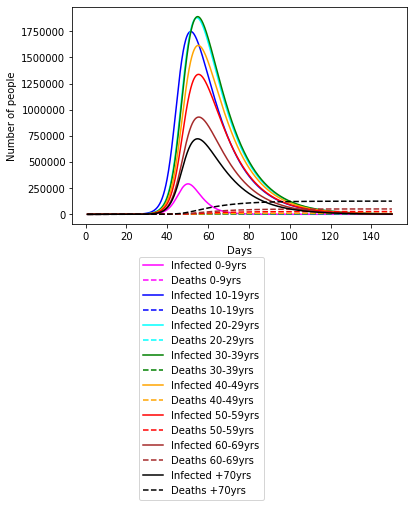

In [9]:
plt.plot(t, I1, label = 'Infected 0-9yrs', color = 'magenta')
plt.plot(t, M1, linestyle = '--', label= 'Deaths 0-9yrs', color = 'magenta')
plt.plot(t, I2, label = 'Infected 10-19yrs', color = 'blue')
plt.plot(t, M2, linestyle = '--', label= 'Deaths 10-19yrs', color = 'blue')
plt.plot(t, I3, label = 'Infected 20-29yrs', color = 'cyan')
plt.plot(t, M3, linestyle = '--', label= 'Deaths 20-29yrs', color = 'cyan')
plt.plot(t, I4, label = 'Infected 30-39yrs', color = 'green')
plt.plot(t, M4, linestyle = '--', label= 'Deaths 30-39yrs', color = 'green')
plt.plot(t, I5, label = 'Infected 40-49yrs', color = 'orange')
plt.plot(t, M5, linestyle = '--', label= 'Deaths 40-49yrs', color = 'orange')
plt.plot(t, I6, label = 'Infected 50-59yrs', color = 'red')
plt.plot(t, M6, linestyle = '--', label= 'Deaths 50-59yrs', color = 'red')
plt.plot(t, I7, label = 'Infected 60-69yrs', color = 'brown')
plt.plot(t, M7, linestyle = '--', label= 'Deaths 60-69yrs', color = 'brown')
plt.plot(t, I8, label = 'Infected +70yrs', color = 'black')
plt.plot(t, M8, linestyle = '--', label= 'Deaths +70yrs', color = 'black')
plt.ylabel('Number of people')
plt.xlabel('Days')
lgd = plt.legend(bbox_to_anchor=(0.2, -0.15), loc='upper left', borderaxespad=0.)


Although we have a lot of curves here, it is possible to see some intersting behaviors. Firts, the highest curve of death is on the older populations, second, the highest peak is on the populations between 10 to 39 years. We see that the young population is the one who gets more infected, but the older population is the one who pays the price.

Another interesting analysis is to plot the cumulative number of hospitalizations. For that, https://www.statista.com/statistics/1105402/covid-hospitalization-rates-us-by-age-group/ shows the number of hospitalizations on the United States due to COVID-19 by age group. There we see that the percentage of hospitalizations for each age group are:

0-19 = 1.6-2.5%

20-44 = 14.3-20.8%

40-54 = 21.2-28.3%

55-64 = 20.5-30.1%

65-74 = 28.6-43.5%

+75 = 30.9-64.5%

Let's evaluate the behavior of such curves. The values presented are not organized in the same groups as we choose, so we will make some adjustments. We are also going to select the lower limit to account for a possible happier scenario in Brazil :)

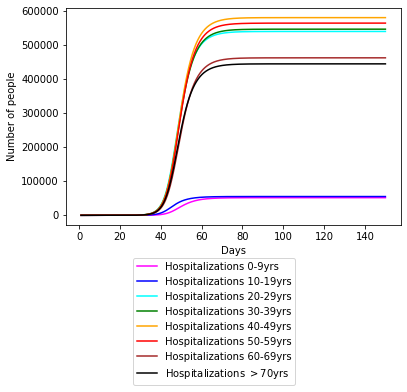

In [10]:
plt.plot(t, 0.016*CT1, label = 'Hospitalizations 0-9yrs', color = 'magenta')
plt.plot(t, 0.016*CT2, label = 'Hospitalizations 10-19yrs', color = 'blue')
plt.plot(t, 0.143*CT3, label = 'Hospitalizations 20-29yrs', color = 'cyan')
plt.plot(t, 0.143*CT4, label = 'Hospitalizations 30-39yrs', color = 'green')
plt.plot(t, 0.177*CT5, label = 'Hospitalizations 40-49yrs', color = 'orange')
plt.plot(t, 0.208*CT6, label = 'Hospitalizations 50-59yrs', color = 'red')
plt.plot(t, 0.245*CT7, label = 'Hospitalizations 60-69yrs', color = 'brown')
plt.plot(t, 0.309*CT8, label = 'Hospitalizations $>$70yrs', color = 'black')
plt.ylabel('Number of people')
plt.xlabel('Days')
lgd = plt.legend(bbox_to_anchor=(0.2, -0.15), loc='upper left', borderaxespad=0.)

Here we see that, although the younger population has a very low curve of deaths, the third more hospitalized population is between 30-39 years followed close by the population of 20-29 years. These age groups are in higher hospitalization numbers that those of more the 60 years. That is a result of the high number of young people on the country.

And finally, we might be interested in seeing the number of critical cases, needing an ICU unit. On Brazil, there are 20523 ICU beds https://www.amib.org.br/fileadmin/user_upload/amib/2018/marco/19/Analise_de_Dados_UTI_Final.pdf on the public health system, and 21218 more on the private system, with a total of 41741 ICU beds. From this number, a high number is already occupied, but we assume here that only 40% of these ICU beds are occupied. Until now, we have no record of an ICU entrance for a patient between 0-19 years because of COVID-19 on the world https://www.vox.com/2020/3/23/21190033/coronavirus-covid-19-deaths-by-age. On Spain, the ICU admitance percentage was 0.6% for 20-29 years, 1.1% for 30-49 years, 3.7% for 50-69 years and 3.2% for olders than 70 years. Yet, the Chinese CDC reports 6.3% of cases from +75 years needed ICU beds, and from 45-54 5.4% needed ICU beds. Adapting those numbers to our model and bringing them to Brazil, we could plot the expectation for ICU entries on the country because of COVID-19.

Text(0.5, 1.0, 'Cumulative registration of ICU admissions')

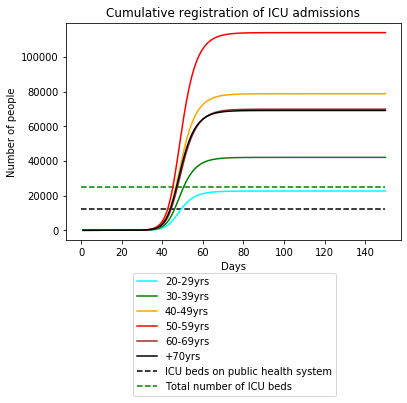

In [12]:
plt.plot(t, 0.006*CT3, label = '20-29yrs', color = 'cyan')
plt.plot(t, 0.011*CT4, label = '30-39yrs', color = 'green')
plt.plot(t, 0.024*CT5, label = '40-49yrs', color = 'orange')
plt.plot(t, 0.042*CT6, label = '50-59yrs', color = 'red')
plt.plot(t, 0.037*CT7, label = '60-69yrs', color = 'brown')
plt.plot(t, 0.048*CT8, label = '+70yrs', color = 'black')
plt.hlines(12314, 0, 150, linestyle = '--', label = 'ICU beds on public health system', color = 'black')
plt.hlines(25045, 0, 150, linestyle = '--', label = 'Total number of ICU beds', color = 'green')
plt.ylabel('Number of people')
plt.xlabel('Days')
lgd = plt.legend(bbox_to_anchor=(0.2, -0.15), loc='upper left', borderaxespad=0.)
plt.title('Cumulative registration of ICU admissions')

Here we finish our series of simulations for the COVID-19 crisis, feel free to check studies and the links posted to change the parameters, population distribution by age, mortality rates and etc.

Ok, what if we placed everybody above 60 years old at home while the others keep their lives to sustain the economy? Well, that is equivalent to decrease the social interaction only on the groups 7 and 8. For the sake of optmism, let's suppose that this type of intervention decreases social interaction on those groups by 90%.

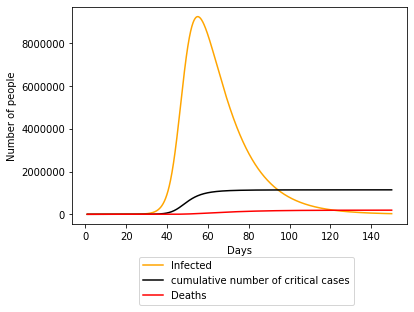

In [13]:
def Corona6(x,t):
    S1 = x[0]
    E1 = x[1]
    I1 = x[2]
    R1 = x[3]
    M1 = x[4]
    
    S2 = x[5]
    E2 = x[6]
    I2 = x[7]
    R2 = x[8]
    M2 = x[9]
    
    S3 = x[10]
    E3 = x[11]
    I3 = x[12]
    R3 = x[13]
    M3 = x[14]
    
    S4 = x[15]
    E4 = x[16]
    I4 = x[17]
    R4 = x[18]
    M4 = x[19]
    
    S5 = x[20]
    E5 = x[21]
    I5 = x[22]
    R5 = x[23]
    M5 = x[24]
    
    S6 = x[25]
    E6 = x[26]
    I6 = x[27]
    R6 = x[28]
    M6 = x[29]
    
    S7 = x[30]
    E7 = x[31]
    I7 = x[32]
    R7 = x[33]
    M7 = x[34]
    
    S8 = x[35]
    E8 = x[36]
    I8 = x[37]
    R8 = x[38]
    M8 = x[39]
    
    N = 23.6e6
    N1 = 0.137*N
    N2 = 0.146*N
    N3 = 0.160*N
    N4 = 0.162*N
    N5 = 0.139*N
    N6 = 0.115*N
    N7 = 0.080*N
    N8 = 0.061*N
    N = N1 + N2 + N3 + N4 + N5 + N6
    #MATRIZ DA POLONIA
    Cij = np.array([
        [3.21, 0.88, 0.96, 1.39, 0.58, 0.80, 0.43, 0.33],
        [0.56, 8.46, 1.05, 0.96, 0.89, 0.46, 0.26, 0.28],
        [0.50, 0.86, 4.92, 1.33, 1.06, 1.08, 0.26, 0.22],
        [0.91, 0.98, 1.65, 2.89, 1.68, 1.20, 0.54, 0.40],
        [0.35, 0.84, 1.24, 1.57, 2.22, 1.19, 0.42, 0.43],
        [0.48, 0.44, 1.24, 1.12, 1.18, 1.80, 0.53, 0.50],
        [0.44, 0.42, 0.52, 0.86, 0.71, 0.91, 0.91, 0.47],
        [0.33, 0.44, 0.41, 0.61, 0.70, 0.81, 0.45, 0.90]
        ])
    
    a = 0.071
    c = 1/5.2
    mu = 0.053
    Pb = 0.11
    Pk = Pb*0.08
    Ej = np.array([E1,E2,E3,E4,E5,E6,E7,E8])
    Ij = np.array([I1,I2,I3,I4,I5,I6,I7,I8])
    B1j = sum(Cij[0,:]*Ij)
    k1j = sum(Cij[0,:]*Ej)
    
    B1 = (B1j*Pb/N1)
    c1 = c
    a1 = 10*a
    mu1 = 0
    k1 = k1j*Pk/N1 
    dS1dt = -B1*S1 - k1*S1
    dE1dt = B1*S1 - c1*E1 + k1*S1
    dI1dt = c1*E1 - a1*I1 - mu1*I1
    dR1dt = a1*I1
    dM1dt = mu1*I1
    
    
    B2j = sum(Cij[1,:]*Ij)
    k2j = sum(Cij[1,:]*Ej)
    
    B2 = (B2j*Pb/N2)
    c2 = c
    a2 = (1-0.002)*a
    mu2 = 0.002*mu
    k2 = k2j*Pk/N2
    dS2dt = -B2*S2 - k2*S2
    dE2dt = B2*S2 - c2*E2 + k2*S2
    dI2dt = c2*E2 - a2*I2 - mu2*I2
    dR2dt = a2*I2
    dM2dt = mu2*I2
    
    
    B3j = sum(Cij[2,:]*Ij)
    k3j = sum(Cij[2,:]*Ej)
    
    B3 = (B3j*Pb/N3)
    c3 = c
    a3 = (1-0.002)*a
    mu3 = 0.002*mu
    k3 = k3j*Pk/N3
    dS3dt = -B3*S3 - k3*S3
    dE3dt = B3*S3 - c3*E3 + k3*S3
    dI3dt = c3*E3 - a3*I3 - mu3*I3
    dR3dt = a3*I3
    dM3dt = mu3*I3
    
    
    B4j = sum(Cij[3,:]*Ij)
    k4j = sum(Cij[3,:]*Ej)
    
    B4 = (B4j*Pb/N4)
    c4 = c
    a4 = (1-0.002)*a
    mu4 = 0.002*mu
    k4 = k4j*Pk/N4 
    dS4dt = -B4*S4 - k4*S4
    dE4dt = B4*S4 - c4*E4 + k4*S4
    dI4dt = c4*E4 - a4*I4 - mu4*I4
    dR4dt = a4*I4
    dM4dt = mu4*I4
    
    
    B5j = sum(Cij[4,:]*Ij)
    k5j = sum(Cij[4,:]*Ej)
    
    B5 = (B5j*Pb/N5)
    c5 = c
    a5 = (1-0.004)*a
    mu5 = 0.004*mu
    k5 = k5j*Pk/N5 
    dS5dt = -B5*S5 - k5*S5
    dE5dt = B5*S5 - c5*E5 + k5*S5
    dI5dt = c5*E5 - a5*I5 - mu5*I5
    dR5dt = a5*I5
    dM5dt = mu5*I5
    
    
    B6j = sum(Cij[5,:]*Ij)
    k6j = sum(Cij[5,:]*Ej)
    
    B6 = (B6j*Pb/N6)
    c6 = c
    a6 = (1-0.013)*a
    mu6 = 0.013*mu
    k6 = k6j*Pk/N6 
    dS6dt = -B6*S6 - k6*S6
    dE6dt = B6*S6 - c6*E6 + k6*S6
    dI6dt = c6*E6 - a6*I6 - mu6*I6
    dR6dt = a6*I6
    dM6dt = mu6*I6
    
    
    B7j = sum(Cij[6,:]*Ij)
    k7j = sum(Cij[6,:]*Ej)
    
    B7 = 0.9*(B7j*Pb/N7)/(1+0.01*np.exp(t-20)) + 0.1*(B7j*Pb/N7)
    c7 = c
    a7 = (1-0.036)*a
    mu7 = 0.036*mu
    k7 = k7j*Pk/N7 
    dS7dt = -B7*S7 - k7*S7
    dE7dt = B7*S7 - c7*E7 + k7*S7
    dI7dt = c7*E7 - a7*I7 - mu7*I7
    dR7dt = a7*I7
    dM7dt = mu7*I7
    
    
    B8j = sum(Cij[7,:]*Ij)
    k8j = sum(Cij[7,:]*Ej)
    
    B8 = 0.9*(B8j*Pb/N8)/(1+0.01*np.exp(t-20)) + 0.1*(B8j*Pb/N8)
    c8 = c
    a8 = (1-0.114)*a
    mu8 = 0.114*mu
    k8 = k8j*Pk/N8 
    dS8dt = -B8*S8 - k8*S8
    dE8dt = B8*S8 - c8*E8 + k8*S8
    dI8dt = c8*E8 - a8*I8 - mu8*I8
    dR8dt = a8*I8
    dM8dt = mu8*I8
    return [dS1dt, dE1dt, dI1dt, dR1dt, dM1dt,
            dS2dt, dE2dt, dI2dt, dR2dt, dM2dt,
            dS3dt, dE3dt, dI3dt, dR3dt, dM3dt,
            dS4dt, dE4dt, dI4dt, dR4dt, dM4dt,
            dS5dt, dE5dt, dI5dt, dR5dt, dM5dt,
            dS6dt, dE6dt, dI6dt, dR6dt, dM6dt,
            dS7dt, dE7dt, dI7dt, dR7dt, dM7dt,
            dS8dt, dE8dt, dI8dt, dR8dt, dM8dt]

N = 23.6e6
N1 = 0.137*N
N2 = 0.146*N
N3 = 0.160*N
N4 = 0.162*N
N5 = 0.139*N
N6 = 0.115*N
N7 = 0.080*N
N8 = 0.061*N
I10 = 0
I20 = 0
I30 = 0
I40 = 1
I50 = 0
I60 = 0
I70 = 2
I80 = 1


x0 = [N1,0,I10,0,0,
      N2,0,I20,0,0,
      N3,0,I30,0,0,
      N4,0,I40,0,0,
      N5,0,I50,0,0,
      N6,0,I60,0,0,
      N7,0,I70,0,0,
      N8,0,I80,0,0]
t = np.linspace(1, 150, 1000)
x = odeint(Corona6, x0, t)

S1 = x[:,0]
E1 = x[:,1]
I1 = x[:,2]
R1 = x[:,3]
M1 = x[:,4]
CT1 = M1 + R1 + I1
S2 = x[:,5]
E2 = x[:,6]
I2 = x[:,7]
R2 = x[:,8]
M2 = x[:,9]
CT2 = M2 + R2 + I2
S3 = x[:,10]
E3 = x[:,11]
I3 = x[:,12]
R3 = x[:,13]
M3 = x[:,14]
CT3 = M3 + R3 + I3
S4 = x[:,15]
E4 = x[:,16]
I4 = x[:,17]
R4 = x[:,18]
M4 = x[:,19]
CT4 = M4 + R4 + I4
S5 = x[:,20]
E5 = x[:,21]
I5 = x[:,22]
R5 = x[:,23]
M5 = x[:,24]
CT5 = M5 + R5 + I5
S6 = x[:,25]
E6 = x[:,26]
I6 = x[:,27]
R6 = x[:,28]
M6 = x[:,29]
CT6 = M6 + R6 + I6
S7 = x[:,30]
E7 = x[:,31]
I7 = x[:,32]
R7 = x[:,33]
M7 = x[:,34]
CT7 = M7 + R7 + I7
S8 = x[:,35]
E8 = x[:,36]
I8 = x[:,37]
R8 = x[:,38]
M8 = x[:,39]
CT8 = M8 + R8 + I8

I = I1 + I2 + I3 + I4 + I5 + I6 + I7 + I8
M = M1 + M2 + M3 + M4 + M5 + M6 + M7 + M8
CT = CT1 + CT2 + CT3 + CT4 + CT5 + CT6 + CT7 + CT8

plt.plot(t, I, label = 'Infected', color = 'orange')
plt.plot(t, 0.05*CT, color = 'black', label = 'cumulative number of critical cases')
plt.plot(t, M, label= 'Deaths', color = 'red')
plt.ylabel('Number of people')
plt.xlabel('Days')
lgd = plt.legend(bbox_to_anchor=(0.2, -0.15), loc='upper left', borderaxespad=0.)

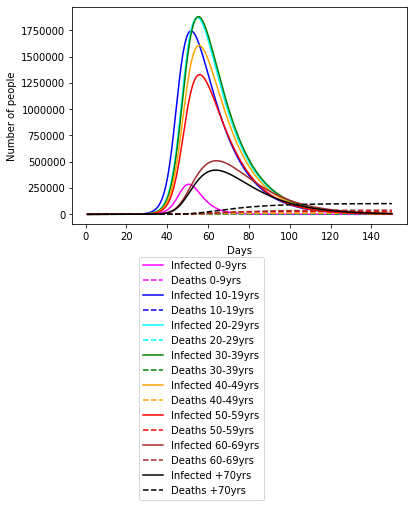

In [14]:
plt.plot(t, I1, label = 'Infected 0-9yrs', color = 'magenta')
plt.plot(t, M1, linestyle = '--', label= 'Deaths 0-9yrs', color = 'magenta')
plt.plot(t, I2, label = 'Infected 10-19yrs', color = 'blue')
plt.plot(t, M2, linestyle = '--', label= 'Deaths 10-19yrs', color = 'blue')
plt.plot(t, I3, label = 'Infected 20-29yrs', color = 'cyan')
plt.plot(t, M3, linestyle = '--', label= 'Deaths 20-29yrs', color = 'cyan')
plt.plot(t, I4, label = 'Infected 30-39yrs', color = 'green')
plt.plot(t, M4, linestyle = '--', label= 'Deaths 30-39yrs', color = 'green')
plt.plot(t, I5, label = 'Infected 40-49yrs', color = 'orange')
plt.plot(t, M5, linestyle = '--', label= 'Deaths 40-49yrs', color = 'orange')
plt.plot(t, I6, label = 'Infected 50-59yrs', color = 'red')
plt.plot(t, M6, linestyle = '--', label= 'Deaths 50-59yrs', color = 'red')
plt.plot(t, I7, label = 'Infected 60-69yrs', color = 'brown')
plt.plot(t, M7, linestyle = '--', label= 'Deaths 60-69yrs', color = 'brown')
plt.plot(t, I8, label = 'Infected +70yrs', color = 'black')
plt.plot(t, M8, linestyle = '--', label= 'Deaths +70yrs', color = 'black')
plt.ylabel('Number of people')
plt.xlabel('Days')
lgd = plt.legend(bbox_to_anchor=(0.2, -0.15), loc='upper left', borderaxespad=0.)

It does not seem a very effective method, we decrease the infection curve on older people a little, but just a little, because even though their social interaction is pretty low, the number of younger people contaminated still is high enough to bring the disease to the older group. For example, you could imagine that even though an fluffy grandmother stays home while her son goes to work, her son will probably get the disease at some point and when he goes home, he will infect his mother. That is why we see the old populations curves moved to the right, meaning that they still get infected and still die a lot, but they become infected later.

# Using the data from some countries to test the model

We have achieved quite a lot until now, and it is time to take a bigger step. Let's test the SEIRD model against real data on the COVID-19 pandemic crisis. For our first test, China's data seems like a good start. China has already gone through most of the crisis and it is now on the final stages, meaning that we have the complete behavior on the disease embeded on China's data. Of course, the data is susceptible to erros, it is not an easy task to keep track of a disease outbreak. But fortunately, if we assume a constant error, say 86% (meaning that the real values for infections are 86% higher than the ones measured [1]), the solutions of the equations are still the same, that is, the behavior of the curves is still the same. It is equivalently of bringing the curve up or down, but not changing the shape of it.

For a start, we need to import data from China from somewhere. I uploded a .txt file here on Github with data from China since 31/12/2019 :), we just need to tell the program to download it.

In [47]:
url = 'https://raw.githubusercontent.com/PedroHPCintra/Coronavirus/master/ChinaInfectadosInicio.txt'
ChinInfec = pd.read_csv(url)
ChinInfec.head(5)

,China Infectados desde o inicio
0,26
1,27
2,28
3,44
4,45


That is the chinese data on infected population, we will also need the China number of deaths and reacoveries. Also, we need to define the time axis, the data here starts on 31/12/2019 and contains the number for each day before it, so we just need to create an array of numbers progressing one by one, for example 1,2,3,4... until the most recent entry of the data.

In [24]:
tf=len(ChinInfec)
t = np.linspace(1, tf, tf)

print(t)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90.
 91. 92. 93. 94. 95. 96. 97. 98. 99.]


In [48]:
url = 'https://raw.githubusercontent.com/PedroHPCintra/Coronavirus/master/ChinaMortosInicio.txt'
ChinDead = pd.read_csv(url)
ChinDead.head(5)

url = 'https://raw.githubusercontent.com/PedroHPCintra/Coronavirus/master/ChinaCasosTotaisInicio.txt'
ChinTot = pd.read_csv(url)
ChinTot.head(5)

,Casos Totais desde o inicio
0,27
1,27
2,27
3,44
4,44


Plotting these values it is possible to see the overral behavior of the disease.

Text(0, 0.5, 'Number of people')

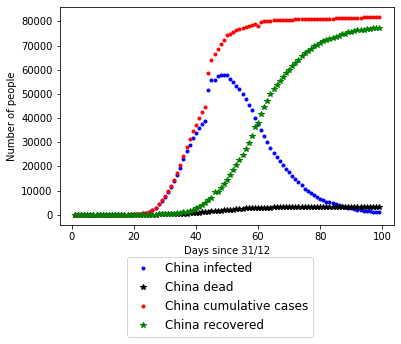

In [54]:
ci = ChinInfec.values
cd = ChinDead.values
ct = ChinTot.values
cr = ct - ci - cd

plt.plot(t, ci, 'b.' ,label = 'China infected')
plt.plot(t, cd, 'k*', label = 'China dead')
plt.plot(t, ct, 'r.', label = 'China cumulative cases')
plt.plot(t, cr, 'g*', label = 'China recovered')
lgd = plt.legend(bbox_to_anchor=(0.2, -0.15), loc='upper left', borderaxespad=0., fontsize = 12)
plt.xlabel('Days since 31/12')
plt.ylabel('Number of people')

Well, this looks like the simulated curves of the SEIRD model, good start. It is time now to fit the simulation onto the data and extract some parameters. We could fit the curves one by one, but we have a lot of parameters and with that much of free parameters, it is possible that more than one set of parameters fit the same curve. For example, if I tell you that two numbers multiplied by each other are equal to 6 and ask you which are these numbers, you could find many pairs of numbers that fit this description, such as 2 and 3, or 1 and 6, or 1.2 and 5... Something like this happens here with we try to make one fit with all of the free parameters of the equations.

To solve this problem, we will choose two curves to fit at the same time, with the same simulation! That is like imposing another condition on the parameters. For example, now I tell you that two numbers multiplied together give 6, but also that the sum of these numbers is 5. Now there is less possibilities, only 2 and 3!

Of course, this was a simple analogy, and using only two numbers, that is, two parameters. On the fit we have $\mu$, $\alpha$, $\beta$, $I_0$, $N$, $c$ and $k$. That is still a lot and two conditions might not be enough. A good strategy for diminishing this number of parameters is setting some of them already constant. For that, we choose $c = 1/5.2$ (extracted from the average of other studies who measured the incubation period of the COVID-19 [2], [3], [4]) and $k=0.09\beta$ (extracted from [6] who measured the rate of transmission of asymptomatic cases). With that in hands, we decrease the number of free parameters. Of course, we could extract more information from other studies and restrict the number of parameters even more, but then we star losing power of adjustment on our simulation.

mu = 0.002113192778641243 +/- 8.837937076841078e-05
a = 0.10846818316388974 +/- 0.003409195080981108
b1 = 0.5675710226895982 +/- 0.006355692707196388
I0 = 40.66198461974504 +/- 5.098484129962649
N = 184535.84092131935 +/- 5643.620078798055


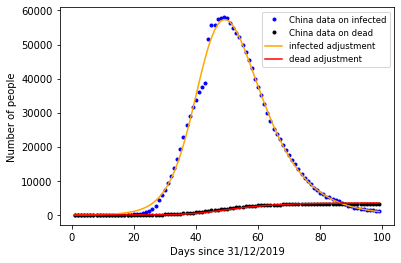

In [81]:
y1 = ci
y2 = cd
y3 = cr
comboY = np.append(y1, y2)
comboX = np.append(t, t)

def mod1(t, mu, a, b1, I0, N):
    def Corona(z,t):
        S = z[0]
        E = z[1]
        I = z[2]
        R = z[3]
        M = z[4]
        b = b1/N
        c = 1/5.2
        k = b1*0.09/N
        dSdt = -b*I*S - k*E*S
        dEdt = b*I*S - c*E + k*E*S
        dIdt = c*E - a*I - mu*I
        dRdt = a*I
        dMdt = mu*I
        return [dSdt, dEdt, dIdt, dRdt, dMdt]
    
    z0 = [N,0,I0,0,0]
    y1 = odeint(Corona, z0, t)
    
    S = y1[:,0]
    E = y1[:,1]
    I = y1[:,2]
    R = y1[:,3]
    M = y1[:,4]
    CT = M + R + I
    return I


def mod2(t, mu, a, b1, I0, N):
    def Corona2(z,t):
        S = z[0]
        E = z[1]
        I = z[2]
        R = z[3]
        M = z[4]
        b = b1/N
        c = 1/5.2
        k = b1*0.09/N
        dSdt = -b*I*S - k*E*S
        dEdt = b*I*S - c*E + k*E*S
        dIdt = c*E - a*I - mu*I
        dRdt = a*I
        dMdt = mu*I
        return [dSdt, dEdt, dIdt, dRdt, dMdt]
    
    z0 = [N,0,I0,0,0]
    y1 = odeint(Corona2, z0, t)
    
    S = y1[:,0]
    E = y1[:,1]
    I = y1[:,2]
    R = y1[:,3]
    M = y1[:,4]
    CT = M + R + I
    return M


def comboFunc(comboData, mu, a, b1, I0, N):
    # single data set passed in, extract separate data
    extract1 = comboData[:len(y1)] # first data
    extract2 = comboData[:len(y1)] # second data
    
    result1 = mod1(extract1, mu, a, b1, I0, N)
    result2 = mod2(extract2, mu, a, b1, I0, N)
    
    return np.append(result1, result2)


# some initial parameter values
initialParameters = np.array([0.03, 0.04, 0.4, 20, 80000])

# curve fit the combined data to the combined function
fittedParameters, pcov = curve_fit(comboFunc, comboX, comboY, initialParameters)

# values for display of fitted function
mu, a, b1, I0, N = fittedParameters

y_fit_1 = mod1(t, mu, a, b1, I0, N) # first data set, first equation
y_fit_2 = mod2(t, mu, a, b1, I0, N) # second data set, second equation

plt.plot(t, y1, 'b.', label = 'China data on infected')
plt.plot(t, y2, 'k.', label = 'China data on dead')
plt.plot(t, y_fit_1 , label = 'infected adjustment', color = 'orange') # plot the equation using the fitted parameters
plt.plot(t, y_fit_2, label = 'dead adjustment', color = 'red') # plot the equation using the fitted parameters
plt.xlabel('Days since 31/12/2019')
plt.ylabel('Number of people')
plt.legend(loc='best', fontsize = 8.5)

print('mu =', fittedParameters[0], '+/-', pcov[0,0]**0.5)
print('a =', fittedParameters[1], '+/-', pcov[1,1]**0.5)
print('b1 =', fittedParameters[2], '+/-', pcov[2,2]**0.5)
print('I0 =', fittedParameters[3], '+/-', pcov[3,3]**0.5)
print('N =', fittedParameters[4], '+/-', pcov[4,4]**0.5)

Well, that is nice! Fits quite perfectly. From this fit we find $\beta = 0.567 \pm 0.006$ and $\mu = 0.00211 \pm 0.00008$, the number for $\alpha$ could be right, but the most probable way to get a more accurate value for $\alpha$ is to fit the curve for recoveries. We can think that, the thing that most changes the shape of the curve for infected is $\beta$, the thing that most changes the shape of deaths is $\mu$ and the thing that most changes the shape of recoveries is $\alpha$, so $\alpha$ is the dominant parameter on the curve of recoveries. Makes sense to fit this curve as well to acquire the most precise value for $\alpha$.

mu = 0.005593266922508349 +/- 0.00034187194911544503
a = 0.1140664509261407 +/- 0.0065244920358044686
b1 = 0.5494600912110875 +/- 0.006059339426902393
I0 = 5.129745538230918 +/- 0.7128901694845929
N = 82498.47856349802 +/- 186.55999178254174


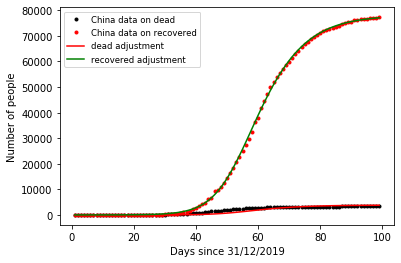

In [80]:
y1 = ci
y2 = cd
y3 = cr
comboY = np.append(y2, y3)
comboX = np.append(t, t)


def mod2(t, mu, a, b1, I0, N):
    def Corona2(z,t):
        S = z[0]
        E = z[1]
        I = z[2]
        R = z[3]
        M = z[4]
        b = b1/N
        c = 1/5.2
        k = b1*0.09/N
        dSdt = -b*I*S - k*E*S
        dEdt = b*I*S - c*E + k*E*S
        dIdt = c*E - a*I - mu*I
        dRdt = a*I
        dMdt = mu*I
        return [dSdt, dEdt, dIdt, dRdt, dMdt]
    
    z0 = [N,0,I0,0,0]
    y1 = odeint(Corona2, z0, t)
    
    S = y1[:,0]
    E = y1[:,1]
    I = y1[:,2]
    R = y1[:,3]
    M = y1[:,4]
    CT = M + R + I
    return M


def mod3(t, mu, a, b1, I0, N):
    def Corona3(z,t):
        S = z[0]
        E = z[1]
        I = z[2]
        R = z[3]
        M = z[4]
        b = b1/N
        c = 1/5.2
        k = b1*0.09/N
        dSdt = -b*I*S - k*E*S
        dEdt = b*I*S - c*E + k*E*S
        dIdt = c*E - a*I - mu*I
        dRdt = a*I
        dMdt = mu*I
        return [dSdt, dEdt, dIdt, dRdt, dMdt]
    
    z0 = [N,0,I0,0,0]
    y1 = odeint(Corona3, z0, t)
    
    S = y1[:,0]
    E = y1[:,1]
    I = y1[:,2]
    R = y1[:,3]
    M = y1[:,4]
    CT = M + R + I
    return R


def comboFunc(comboData, mu, a, b1, I0, N):
    # single data set passed in, extract separate data
    extract2 = comboData[:len(y1)] # second data
    extract3 = comboData[:len(y1)]
    
    result2 = mod2(extract2, mu, a, b1, I0, N)
    result3 = mod3(extract3, mu, a, b1, I0, N)
    
    return np.append(result2, result3)


# some initial parameter values
initialParameters = np.array([0.03, 0.03, 0.4, 20, 80000])

# curve fit the combined data to the combined function
fittedParameters, pcov = curve_fit(comboFunc, comboX, comboY, initialParameters)

# values for display of fitted function
mu, a, b1, I0, N = fittedParameters

y_fit_2 = mod2(t, mu, a, b1, I0, N) # second data set, second equation
y_fit_3 = mod3(t, mu, a, b1, I0, N)

plt.plot(t, y2, 'k.', label = 'China data on dead')
plt.plot(t, y3, 'r.', label = 'China data on recovered')
plt.plot(t, y_fit_2, label = 'dead adjustment', color = 'red') # plot the equation using the fitted parameters
plt.plot(t, y_fit_3, label = 'recovered adjustment', color = 'green')
plt.xlabel('Days since 31/12/2019')
plt.ylabel('Number of people')
plt.legend(loc='best', fontsize = 8.5)

print('mu =', fittedParameters[0], '+/-', pcov[0,0]**0.5)
print('a =', fittedParameters[1], '+/-', pcov[1,1]**0.5)
print('b1 =', fittedParameters[2], '+/-', pcov[2,2]**0.5)
print('I0 =', fittedParameters[3], '+/-', pcov[3,3]**0.5)
print('N =', fittedParameters[4], '+/-', pcov[4,4]**0.5)

Nice, see that the parameters $\mu$ and $\beta$ didn't change that much? That is a good sign that our model is really finding the best parameters that describe the behavior of the curve!
Here, $\alpha = 0.114 \pm 0.006$, from the first fit we found $\alpha = 0.108 \pm 0.003$, that is still inside the margin of error for the ''correct'' value. We will take the averages of these values in order to find the parameters and atribute clinical results for the disease. Taking an average, we find

$$\alpha = 0.111 \pm 0.004$$

$$\mu = 0.0038 \pm 0.0002$$

$$\beta = 0.558 \pm 0.006$$

With these values, we can estimate the average time for recovery, the average time until death, knowing the mortality rate of the country. Also, we can estimate the $\mathcal{R}_0$ factor, which is called Basic Reproduction Number, it measures how many people on average, one infected person infects. If $\mathcal{R}_0$ is lower than 1, the infection is not sustained and does not spread.

$$\mathcal{R}_0 = \frac{k(\alpha + \beta) + \beta c}{c(\alpha + \mu)}$$

$$\mathcal{R}_0 = 2.97 \pm 0.25$$

Average time for recovery from symptoms onset = 8.7 days

Average time for death from symptoms onset = 8 days

It seems the model works pretty well, but China has already passed the crisis, how about now we run some predictions for an ''active'' country? Let's take Italy's example. I will download Italy's numbers for the first days and using the fit to extract parameters, we will try to guess it's behavior for the rest of the crisis and later compare it with the actual data. But, before we do it, there is a point we need to remember... the uncertainty on $N$, if we leave it as a free parameter, the fitting program will try to find one that adjusts this data best. That is an overfitting, we will be making the fit so good to this specif set of data, that it will no be generalizable enough to carry a prediction. To avoid that, we must think of a way to restric $N$, but what value should we choose?

The method we will use here to impose a restriction on $N$ will be use the $\chi^2$ value of the fit for different $N$s to set a maximum value $N_{max}$. How will it work?

The $\chi^2$ is a measurement of how good a curve fits the data, for different values of $N$, the program will find different values for the other parameters, resulting on different curves and therefore different results on the $\chi^2$ test. If you want to know more about this test for fitting data, you can start by the wikipedia page https://en.wikipedia.org/wiki/Chi-squared_test. The result of the test goes from 0 to 1, the closer to 1, the better the fitting. So let's set a minimum acceptance for this result: We will exclude all values of $N$ that yield a $\chi^2 < 0.98$ for any of the curves fitted.

Honestly, I could probably run a loop program to do that and give me the results, by I decided to do it by hand (because why not?) and the result is that for $N > 800000$ we find $\chi^2 < 0.98$, and so we set $N_{max} = 800000$. We choose a minimum value for $N$ as half the maximum value, so $N_{min} = 400000$. Our prediction should be on this range, a minimum fit for $N_{min}$ and a maximum fit for $N_{max}$. Here, I will place the code for just one fit, but if you want to run it for the other limit, you just have to change the value of $N$ on the code.

Chi1^2:  0.9929119635635361
Chi2^2:  0.9808447288242113
mu = 0.015125683133403055 +/- 0.0014143915828788351
a = 0.04409798725640526 +/- 0.03718342197231909
b1 = 0.3683083699720148 +/- 0.07820937324602752
I0 = 360.62577513632 +/- 38.599270670618516


IndexError: index 4 is out of bounds for axis 0 with size 4

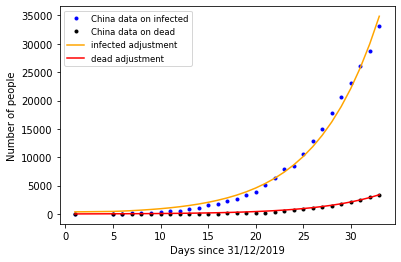

In [163]:
url = 'https://raw.githubusercontent.com/PedroHPCintra/Coronavirus/master/ItaliaeixoXate1703.txt'
Itx = pd.read_csv(url)
Itx.head(5)

url = 'https://raw.githubusercontent.com/PedroHPCintra/Coronavirus/master/ItaliaInfectadosate1703.txt'
ItInfec = pd.read_csv(url)
ItInfec.head(5)

url = 'https://raw.githubusercontent.com/PedroHPCintra/Coronavirus/master/ItaliaMortosate1703.txt'
ItDead = pd.read_csv(url)
ItDead.head(5)

y1 = ItInfec.values.ravel()
y2 = ItDead.values.ravel()
comboY = np.append(y1, y2)
t = Itx.values.ravel()
comboX = np.append(t, t)

def mod1(t, mu, a, b1, I0):
    def Corona(z,t):
        S = z[0]
        E = z[1]
        I = z[2]
        R = z[3]
        M = z[4]
        b = b1/N
        c = 1/5.2
        k = b1*0.09/N
        dSdt = -b*I*S - k*E*S
        dEdt = b*I*S - c*E + k*E*S
        dIdt = c*E - a*I - mu*I
        dRdt = a*I
        dMdt = mu*I
        return [dSdt, dEdt, dIdt, dRdt, dMdt]
    N = 8e5
    z0 = [N,0,I0,0,0]
    y1 = odeint(Corona, z0, t)
    
    S = y1[:,0]
    E = y1[:,1]
    I = y1[:,2]
    R = y1[:,3]
    M = y1[:,4]
    CT = M + R + I
    return I


def mod2(t, mu, a, b1, I0):
    def Corona2(z,t):
        S = z[0]
        E = z[1]
        I = z[2]
        R = z[3]
        M = z[4]
        b = b1/N
        c = 1/5.2
        k = b1*0.09/N
        dSdt = -b*I*S - k*E*S
        dEdt = b*I*S - c*E + k*E*S
        dIdt = c*E - a*I - mu*I
        dRdt = a*I
        dMdt = mu*I
        return [dSdt, dEdt, dIdt, dRdt, dMdt]
    N = 8e5
    z0 = [N,0,I0,0,0]
    y1 = odeint(Corona2, z0, t)
    
    S = y1[:,0]
    E = y1[:,1]
    I = y1[:,2]
    R = y1[:,3]
    M = y1[:,4]
    CT = M + R + I
    return M


def comboFunc(comboData, mu, a, b1, I0):
    # single data set passed in, extract separate data
    extract1 = comboData[:len(y1)] # first data
    extract2 = comboData[:len(y1)] # second data
    
    result1 = mod1(extract1, mu, a, b1, I0)
    result2 = mod2(extract2, mu, a, b1, I0)
    
    return np.append(result1, result2)


# some initial parameter values
initialParameters = np.array([0.03, 0.04, 0.4, 20])

# curve fit the combined data to the combined function
fittedParameters, pcov = curve_fit(comboFunc, comboX, comboY, initialParameters, bounds=(0, [1, 1, 1, 1000]))

# values for display of fitted function
mu, a, b1, I0 = fittedParameters

y_fit_1 = mod1(t, mu, a, b1, I0) # first data set, first equation
y_fit_2 = mod2(t, mu, a, b1, I0) # second data set, second equation

plt.plot(t, y1, 'b.', label = 'China data on infected')
plt.plot(t, y2, 'k.', label = 'China data on dead')
plt.plot(t, y_fit_1 , label = 'infected adjustment', color = 'orange') # plot the equation using the fitted parameters
plt.plot(t, y_fit_2, label = 'dead adjustment', color = 'red') # plot the equation using the fitted parameters
plt.xlabel('Days since 31/12/2019')
plt.ylabel('Number of people')
plt.legend(loc='best', fontsize = 8.5)

print('Chi1^2: ', r2_score(y_fit_1, y1))
print('Chi2^2: ', r2_score(y_fit_2, y2))
print('mu =', fittedParameters[0], '+/-', pcov[0,0]**0.5)
print('a =', fittedParameters[1], '+/-', pcov[1,1]**0.5)
print('b1 =', fittedParameters[2], '+/-', pcov[2,2]**0.5)
print('I0 =', fittedParameters[3], '+/-', pcov[3,3]**0.5)
print('N =', fittedParameters[4], '+/-', pcov[4,4]**0.5)

The values for each of the fits were:

For $N_{min}$:

$$\mu = 0.0152 \pm 0.0012$$

$$\alpha = 0.0641 \pm 0.0642$$

$$\beta = 0.4245 \pm 0.1143$$

$$I_0 = 305 \pm 2$$

For $N_{max}$:

$$\mu = 0.0151 \pm 0.0014$$

$$\alpha = 0.0441 \pm 0.0372$$

$$\beta = 0.3683 \pm 0.0782$$

$$I_0 = 361 \pm 39$$

You might notice that the value for $\alpha$ has a very large error associated with it. That's because we did not perform the fit for the recovered curve, which allows for a better estimation of $\alpha$. Unfortunatelly, Italy's data does not include a curve for recovered population (At least not until I create this program). Now, Italy pronounced a lock-down of the Lombardy on March 9th, 24 days after the first data point we have, ate February 15th. So let's run our predictions with our non-pharmaceutical intervention starting on $t_c = 24$. Let's suppose 2 scenarios of efficiency for the non-pharmaceutical intervention, a 60% efficiency, and a 40% efficiency (Feel free to try constructing more if you want). For each of these, we run a prediction for $N_{max}$ and $N_{min}$, with also a middle of curve between both of them on $N=600000$.

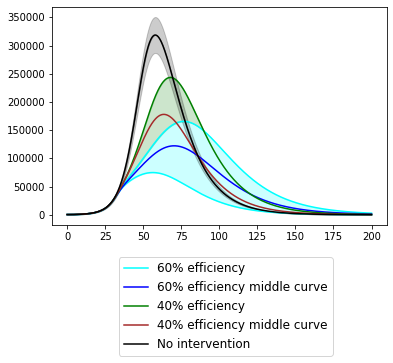

In [188]:
def Corona10min(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.4245/N
    Po = 0.6
    gamma = 0.0003
    tc = 24
    b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi
    a = 0.0641
    mu = 0.0152
    c = 1/5.3
    k = b*0.09
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 4e5
I0 = 305

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona10min, x0, t)

S10min = y[:,0]
E10min = y[:,1]
I10min = y[:,2]
R10min = y[:,3]
D10min = y[:,4]

def Corona10max(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.3683/N
    Po = 0.6
    gamma = 0.0003
    tc = 24
    b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi
    a = 0.0441
    mu = 0.0151
    c = 1/5.3
    k = b*0.09
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 8e5
I0 = 361

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona10max, x0, t)

S10max = y[:,0]
E10max = y[:,1]
I10max = y[:,2]
R10max = y[:,3]
D10max = y[:,4]

def Corona10mid(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.3778877113871859/N
    Po = 0.6
    gamma = 0.0003
    tc = 24
    b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi
    a = 0.0477401724250240
    mu = 0.014912967983365671
    c = 1/5.3
    k = b*0.09
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 6e5
I0 = 343

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona10mid, x0, t)

S10mid = y[:,0]
E10mid = y[:,1]
I10mid = y[:,2]
R10mid = y[:,3]
D10mid = y[:,4]

def Corona11max(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.3683/N
    Po = 0.4
    gamma = 0.0003
    tc = 24
    b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi
    a = 0.0441
    mu = 0.0151
    c = 1/5.3
    k = b*0.09
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 8e5
I0 = 353

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona11max, x0, t)

S11max = y[:,0]
E11max = y[:,1]
I11max = y[:,2]
R11max = y[:,3]
D11max = y[:,4]

def Corona11mid(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.3778877113871859/N
    Po = 0.4
    gamma = 0.0003
    tc = 24
    b = (Po*bi)/(1 + gamma*np.exp(t-tc)) + (1-Po)*bi
    a = 0.0477401724250240
    mu = 0.014912967983365671
    c = 1/5.3
    k = b*0.09
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 6e5
I0 = 353

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona11mid, x0, t)

S11mid = y[:,0]
E11mid = y[:,1]
I11mid = y[:,2]
R11mid = y[:,3]
D11mid = y[:,4]

def Corona12(x,t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    M = x[4]
    bi = 0.3778877113871859/N
    b = bi
    a = 0.0477401724250240
    mu = 0.014912967983365671
    c = 1/5.3
    k = b*0.09
    dSdt = -b*I*S - k*E*S
    dEdt = b*I*S - c*E + k*E*S
    dIdt = c*E - a*I - mu*I
    dRdt = a*I
    dMdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dMdt]

N = 8e5
I0 = 353

x0 = [N,0,I0,0,0]
t = np.linspace(0, 200, 1000)

y = odeint(Corona12, x0, t)

S12 = y[:,0]
E12 = y[:,1]
I12 = y[:,2]
R12 = y[:,3]
D12 = y[:,4]

plt.plot(t, I10min, color = 'cyan', label = '60% efficiency')
plt.plot(t, I10max, color = 'cyan')
plt.plot(t, I10mid, color = 'blue', label = '60% efficiency middle curve')
plt.plot(t, I11max, color = 'green', label = '40% efficiency')
plt.plot(t, I11mid, color = 'brown', label = '40% efficiency middle curve')
plt.plot(t, I12, color = 'black', label = 'No intervention')
plt.fill_between(t, I10min, I10max, color = 'cyan', alpha = 0.2)
plt.fill_between(t, I10max, I11max, where = I11max >= I10max, color = 'green', alpha = 0.2)
plt.fill_between(t, I12, 1.1*I12, color = 'black', alpha = 0.2)
plt.fill_between(t, I12, 0.9*I12, color = 'black', alpha = 0.2)
lgd = plt.legend(bbox_to_anchor=(0.2, -0.15), loc='upper left', borderaxespad=0., fontsize = 12)

We have our scenarios, it is time to plot it against the most recent data of Italy.

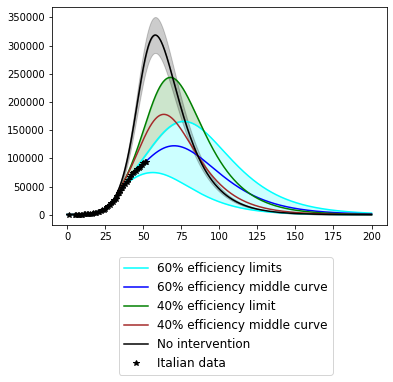

In [194]:
url = 'https://raw.githubusercontent.com/PedroHPCintra/Coronavirus/master/ItaliaeixoX.txt'
Itx2 = pd.read_csv(url)
Itx.head(5)

url = 'https://raw.githubusercontent.com/PedroHPCintra/Coronavirus/master/ItaliaInfectados.txt'
ItInfec2 = pd.read_csv(url)
ItInfec.head(5)

url = 'https://raw.githubusercontent.com/PedroHPCintra/Coronavirus/master/ItaliaMortos.txt'
ItDead2 = pd.read_csv(url)
ItDead.head(5)

x2 = Itx2.values.ravel()
i2 = ItInfec2.values.ravel()

plt.plot(t, I10min, color = 'cyan', label = '60% efficiency limits')
plt.plot(t, I10max, color = 'cyan')
plt.plot(t, I10mid, color = 'blue', label = '60% efficiency middle curve')
plt.plot(t, I11max, color = 'green', label = '40% efficiency limit')
plt.plot(t, I11mid, color = 'brown', label = '40% efficiency middle curve')
plt.plot(t, I12, color = 'black', label = 'No intervention')
plt.fill_between(t, I10min, I10max, color = 'cyan', alpha = 0.2)
plt.fill_between(t, I10max, I11max, where = I11max >= I10max, color = 'green', alpha = 0.2)
plt.fill_between(t, I12, 1.1*I12, color = 'black', alpha = 0.2)
plt.fill_between(t, I12, 0.9*I12, color = 'black', alpha = 0.2)
plt.plot(x2, i2, 'k*', label = 'Italian data')
lgd = plt.legend(bbox_to_anchor=(0.2, -0.15), loc='upper left', borderaxespad=0., fontsize = 12)

The data suggest Italy finds itself on a 60% efficient lock-down! Let's take a better look at this!

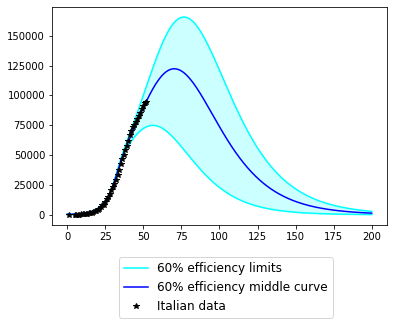

In [193]:
plt.plot(t, I10min, color = 'cyan', label = '60% efficiency limits')
plt.plot(t, I10max, color = 'cyan')
plt.plot(t, I10mid, color = 'blue', label = '60% efficiency middle curve')
plt.fill_between(t, I10min, I10max, color = 'cyan', alpha = 0.2)
plt.plot(x2, i2, 'k*', label = 'Italian data')
lgd = plt.legend(bbox_to_anchor=(0.2, -0.15), loc='upper left', borderaxespad=0., fontsize = 12)

SWEET!

# FINISH :D
# Stay Home

# References

[1]. Li, R., Pei, S., Chen, B., Song, Y., Zhang, T., Yang, W., & Shaman, J. (2020). Substantial undocumented infection facilitates the rapid dissemination of novel coronavirus (SARS-CoV2). Science.

[2]. Linton, N. M., Kobayashi, T., Yang, Y., Hayashi, K., Akhmetzhanov, A. R., Jung, S. M., ... & Nishiura, H. (2020). Incubation period and other epidemiological characteristics of 2019 novel coronavirus infections with right truncation: a statistical analysis of publicly available case data. Journal of clinical medicine, 9(2), 538.

[3]. Li, Q., Guan, X., Wu, P., Wang, X., Zhou, L., Tong, Y., ... & Xing, X. (2020). Early transmission dynamics in Wuhan, China, of novel coronavirus–infected pneumonia. New England Journal of Medicine.

[4]. Guan, W. J., Ni, Z. Y., Hu, Y., Liang, W. H., Ou, C. Q., He, J. X., ... & Du, B. (2020). Clinical characteristics of coronavirus disease 2019 in China. New England Journal of Medicine.

[5]. Backer, J. A., Klinkenberg, D., & Wallinga, J. (2020). Incubation period of 2019 novel coronavirus (2019-nCoV) infections among travellers from Wuhan, China, 20–28 January 2020. Eurosurveillance, 25(5).

[6]. Nishiura, H., Kobayashi, T., Yang, Y., Hayashi, K., Miyama, T., Kinoshita, R., ... & Akhmetzhanov, A. R. (2020). The rate of underascertainment of novel coronavirus (2019-nCoV) infection: Estimation using Japanese passengers data on evacuation flights.